# Attention-based MIL demo.

In [1]:
from torch_tools import ShapesDataset
from torch.utils.data import DataLoader

from torch import randn_like

from torch.nn.functional import instance_norm

from torchvision.transforms import Compose, RandomGrayscale, Normalize

img_size = 128
patch_size = 32

data_set = ShapesDataset(
    num_spots=3,
    num_squares=3,
    spots_prob=1.0,
    square_prob=0.5,
    target_tfms=Compose([lambda x: x[1].unsqueeze(0)]),
    input_tfms=RandomGrayscale(p=1.0),
)

data_loader = DataLoader(
    data_set,
    shuffle=False,
    batch_size=1,
    drop_last=True,
)

In [2]:
import torch
from torch.nn import Module, Linear, Sequential, Tanh
from torch.optim import Adam

from torch.cuda import is_available

from torch_tools import ConvNet2d, FCNet, SimpleConvNet2d
from torch_tools.weight_init import normal_init


DEVICE = "cuda" if is_available() else "cpu"


class AttentionNet(Module):
    """Attention model."""

    def __init__(self):
        """Build attention model."""
        super().__init__()

        self.latent = 512
        self.D = 128

        # self.cnn = ConvNet2d(
        #     self.latent,
        #     encoder_style="resnet18",
        #     pretrained=True,
        #     pool_style="avg",
        #     fc_net_kwargs={"hidden_sizes" :(self.latent,), "hidden_dropout" : 0.5},
        # )

        self.cnn = SimpleConvNet2d(3, self.latent, num_blocks=2)


        self.classifier = Linear(self.latent, 1)
        self.attention = Sequential(
            Linear(self.latent, self.D),
            Tanh(),
            Linear(self.D, 1),
        )

    def forward(self, batch):
        """Pass ``batch`` through the model."""
        latent = self.cnn(batch).relu().reshape(-1, self.latent)

        attention = self.attention(latent).transpose(1, 0)
        attention = attention.softmax(dim=1)

        matrix = torch.mm(attention, latent)

        classification = self.classifier(matrix).sigmoid()

        return classification, attention


model = AttentionNet().to(DEVICE)


print(model)


optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

AttentionNet(
  (cnn): SimpleConvNet2d(
    (0): Encoder2d(
      (0): DoubleConvBlock(
        (0): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
        (1): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
      )
      (1): DownBlock(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConvBlock(
          (0): ConvBlock(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): LeakyReLU(negative_slope=0.1)


In [3]:
from typing import Optional

from torch import set_grad_enabled
from torch.nn.functional import binary_cross_entropy as bce

from torch_tools.torch_utils import patchify_img_batch


def one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Optional[Adam] = None,
):
    """Train or validate the model for a single epoch.

    Parameters
    ----------
    model : Module
        Classifier model.
    data_loader : DataLoader
        Image-yielding data loader.
    optimiser : Adam, optional
        The optimiser to fit the model with.

    """
    running_loss = 0.0
    counter = 0

    if optimiser is not None:
        model.train()
    else:
        model.eval()

    with set_grad_enabled(optimiser is not None):
        for image, target in data_loader:
            if optimiser is not None:
                optimiser.zero_grad()

            image, target = image.to(DEVICE), target.to(DEVICE)

            bag = patchify_img_batch(image, patch_size)

            pred, atten = model(bag)

            loss = bce(pred, target)
            running_loss += loss.item()

            if optimiser is not None:
                loss.backward()
                optimiser.step()

            counter += 1

    return running_loss / counter

In [4]:
from pandas import DataFrame

losses = []

for epoch in range(3):
    train_loss = one_epoch(model, data_loader, optimiser)
    valid_loss = one_epoch(model, data_loader)

    losses.append(
        {
            "train_loss": train_loss,
            "valid_loss": valid_loss,
            "epoch": epoch + 1,
        }
    )

losses = DataFrame(losses)

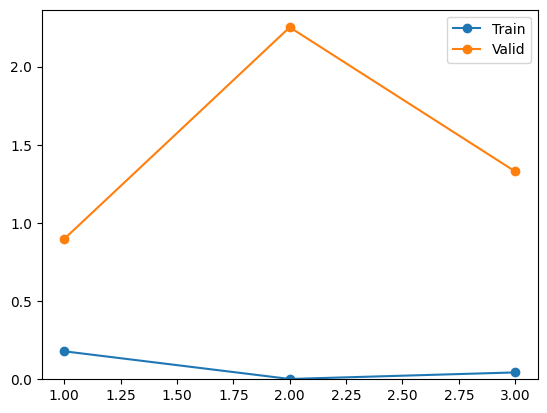

In [5]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 1)

axes.plot(losses.epoch, losses.train_loss, "-o", label="Train")
axes.plot(losses.epoch, losses.valid_loss, "-o", label="Valid")

axes.set_ylim(bottom=0.0)

axes.legend()

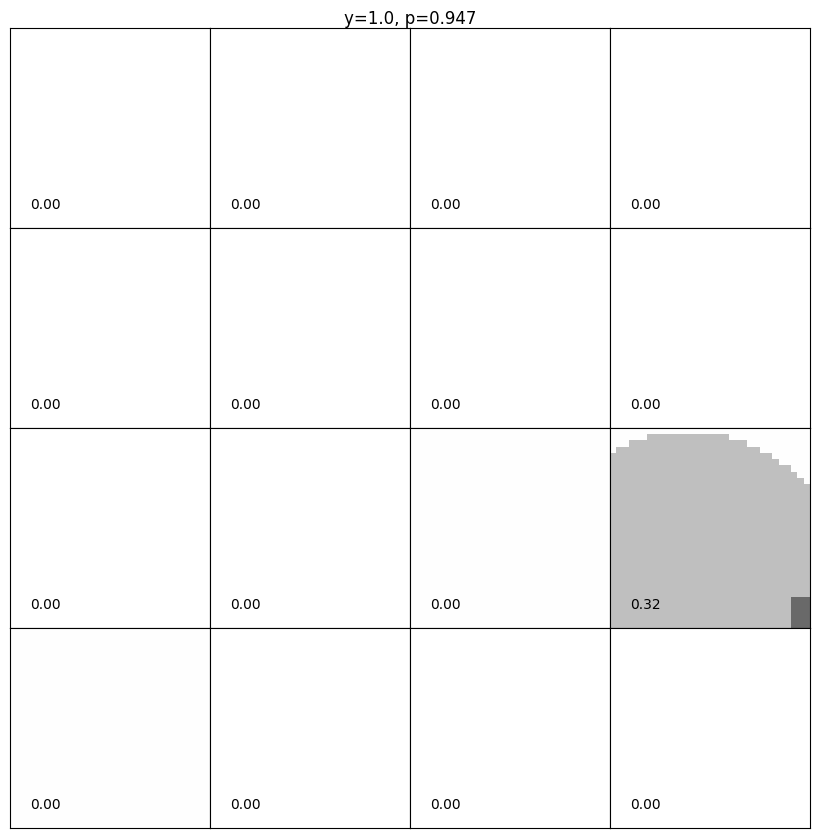

In [6]:
model.eval()

for image, target in data_loader:
    image = patchify_img_batch(image, patch_size)
    pred, attention = model(image.to(DEVICE))

    break

attention = attention.cpu().detach().flatten()
max_att = attention.max().item()

patch_length = img_size // patch_size


figure, axes = plt.subplots(patch_length, patch_length, figsize=(8, 8.2))

for patch, axis, att in zip(image, axes.ravel(), attention):
    patch = patch.permute(1, 2, 0).numpy()

    axis.imshow(patch, alpha=att.item() / max_att)
    axis.text(0.1, 0.1, f"{att.item():.2f}", transform=axis.transAxes)
    axis.set_xticks([])
    axis.set_yticks([])

figure.suptitle(f"y={target.item()}, p={pred.item():.3f}", y=1.0)
figure.tight_layout(pad=0, h_pad=0.0, w_pad=0)